# Encodings for Categorical Variables

How to use chemical and custom encodigns for your categorical variables.

Find more information here:
- [Examples in Different Search Spaces](https://emdgroup.github.io/baybe/examples/Searchspaces/Searchspaces.html)
- [Backtesting Examples](https://emdgroup.github.io/baybe/examples/Backtesting/Backtesting.html)
- [BayBE GitHub](https://github.com/emdgroup/baybe)
- [BayBE Userguide](https://emdgroup.github.io/baybe/userguide/userguide.html)

<a target="_blank" href="https://colab.research.google.com/github/emdgroup/baybe-ac24-workshop/blob/main/2_Encodings.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/emdgroup/baybe-ac24-workshop/HEAD?labpath=2_Encodings.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder"/>
</a>

# Install and Import

In [ ]:
!pip install 'baybe[chem,simulation]==0.10.0' seaborn matplotlib pandas[excel]

In [ ]:
import warnings
from botorch.exceptions import InputDataWarning
warnings.filterwarnings('ignore', category = InputDataWarning)
warnings.filterwarnings('ignore', message = '.*BayBE.*')

import baybe
baybe.__version__

In [2]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

os.environ['BAYBE_CACHE_DIR']='' # turn descriptor caching off
from baybe.utils.random import set_random_seed
set_random_seed(1337)

# Create the Lookup
The problem we study here, corresponds to the chemical reaciton yield optimization from [Shields, B.J., Stevens et al. Nature 590, 89–96 (2021)](https://doi.org/10.1038/s41586-021-03213-y).
![reaction](https://raw.githubusercontent.com/emdgroup/baybe-ac24-workshop/main/files/reaction.png)

The parameters screened are:
- Solvent
- Base
- Ligand
- Concentration (of the solvent)
- Temperature

There is one target that should be maximized:
- yield

In [42]:
url = 'https://raw.githubusercontent.com/emdgroup/baybe/main/examples/Backtesting/lookup.xlsx'
lookup = pd.read_excel(url, index_col=0)
F_BEST = lookup['yield'].max()
lookup.head()

,Base_SMILES,Ligand_SMILES,Solvent_SMILES,Concentration,Temp_C,yield,Base,Ligand,Solvent
entry,,,,,,,,,
0,O=C([O-])C.[K+],CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC...,CC(N(C)C)=O,0.1,105,5.47,Potassium acetate,BrettPhos,DMAc
1,O=C([O-])C.[K+],CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C,CC(N(C)C)=O,0.1,105,0.00,Potassium acetate,Di-tert-butylphenylphosphine,DMAc
2,O=C([O-])C.[K+],CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C...,CC(N(C)C)=O,0.1,105,78.95,Potassium acetate,(t-Bu)PhCPhos,DMAc
3,O=C([O-])C.[K+],P(C1CCCCC1)(C2CCCCC2)C3CCCCC3,CC(N(C)C)=O,0.1,105,7.26,Potassium acetate,Tricyclohexylphosphine,DMAc
4,O=C([O-])C.[K+],P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,CC(N(C)C)=O,0.1,105,28.15,Potassium acetate,PPh3,DMAc


### SMILES
The structure of the molecules is represented by a SMILES, a text based representation of molecules.
In particular for small molecuels it is a convenient way of presenting a molecule in the computer.

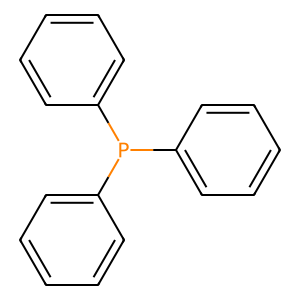

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles('P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3') #PPh3
Draw.MolToImage(mol)

### Target Distribution
This is a needle-in-a-haystack problem.

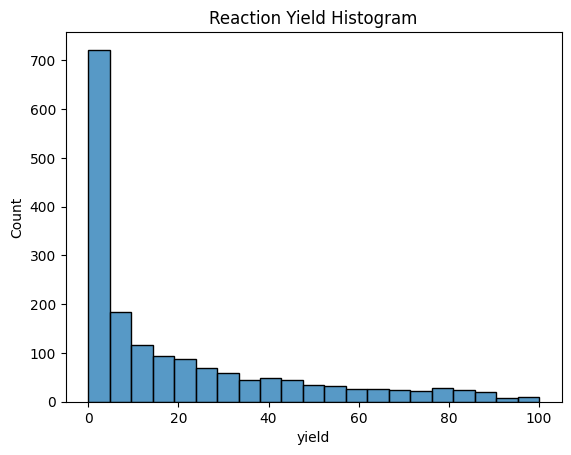

In [5]:
sns.histplot(data = lookup, x = 'yield', edgecolor = 'black');
plt.title('Reaction Yield Histogram');

### Assemble Label-Structure Pairs Needed for the Parameters

In [6]:
solvent_data = dict(sorted(set(zip(lookup.Solvent, lookup.Solvent_SMILES))))
solvent_data

{'Butyl Ester': 'CCCCOC(C)=O',
 'Butyornitrile': 'CCCC#N',
 'DMAc': 'CC(N(C)C)=O',
 'p-Xylene': 'CC1=CC=C(C)C=C1'}

In [7]:
base_data = dict(sorted(set(zip(lookup.Base, lookup.Base_SMILES))))
base_data

{'Cesium acetate': 'O=C([O-])C.[Cs+]',
 'Cesium pivalate': 'O=C([O-])C(C)(C)C.[Cs+]',
 'Potassium acetate': 'O=C([O-])C.[K+]',
 'Potassium pivalate': 'O=C([O-])C(C)(C)C.[K+]'}

In [8]:
ligand_data = dict(sorted(set(zip( lookup.Ligand, lookup.Ligand_SMILES))))
ligand_data

{'(t-Bu)PhCPhos': 'CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3',
 '1268824-69-6': 'CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C',
 'BrettPhos': 'CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC',
 'Di-tert-butylphenylphosphine': 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C',
 'JackiePhos': 'FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1',
 'Me2PPh': 'CP(C)C1=CC=CC=C1',
 'Methyldiphenylphosphine': 'CP(C1=CC=CC=C1)C2=CC=CC=C2',
 'P(2-furyl)3': 'P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3',
 'PPh3': 'P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3',
 'SCHEMBL15068049': 'C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1',
 'Tricyclohexylphosphine': 'P(C1CCCCC1)(C2CCCCC2)C3CCCCC3',
 'XPhos': 'CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C'}

In [9]:
temperature_values = set(lookup.Temp_C)
temperature_values

{90, 105, 120}

In [10]:
concentration_values = set(lookup.Concentration)
concentration_values

{0.057, 0.1, 0.153}

# Create Different Parametrizations

## Set up Parametrization for Solvent, Base, Temp and Concentration

For four out of the five parameters we will keep the parameteriyation the same.

We will encode the base and solvent with the [`SubstanceParameter`](https://emdgroup.github.io/baybe/userguide/parameters.html#substanceparameter) which requires `data` in the form of the above created dictionary mappings between substance labels and their SMILES.

For the temperature and concentration we use the
[`NumericalDiscreteParameter`](https://emdgroup.github.io/baybe/userguide/parameters.html#numericaldiscreteparameter), which simply needs a sequence of `values`.

In [29]:
from baybe.parameters import (SubstanceParameter, 
                              CustomDiscreteParameter, 
                              CategoricalParameter, 
                              NumericalDiscreteParameter)

# Substance parameters including chemical descriptors
p_solvent = SubstanceParameter(name = "Solvent", data = solvent_data)
p_base = SubstanceParameter(name = "Base", data = base_data)

# Discrete numerical parameters
p_temp = NumericalDiscreteParameter(name = "Temp_C", values = temperature_values)
p_concentration = NumericalDiscreteParameter(name = "Concentration", values = concentration_values)

shared_parameters = [
    p_solvent,
    p_base, 
    p_concentration, 
    p_temp
]

## Create Different Ligand Parameterizations

To illustrate the role of featurization for categorical parameters we will create three differen variants for the ligand. In this type of reaction, the ligand is known to play a crucial role.

### MORDRED Encoding

[MORDRED](https://github.com/JacksonBurns/mordred-community) and [RDKIT](https://github.com/rdkit/rdkit) are well known cheminformatics packages which allow manipulation of small molecules, but also calculation of descriptors for them. There exist many decades of work and over the years thousands of descriptors have been developed. In general, these descriptors are quickly calculated, but include several approximations to enable this.

Since surrogate models generally scale with data dimensionality, it is a bad idea to use all of these descriptors. For this, BayBE provides the `decorrelate` keyword. With this you can specify a threshold of pairwise column correlation above which one of the columns will be dropped.

Below we explicitly turn decorrelation off to see the resulting (bad) featurization.

In [30]:
p_ligand_mordred_bad = SubstanceParameter(name = "Ligand",
                                          data = ligand_data,
                                          encoding = 'MORDRED', # MORDRED or RDKIT or MORGAN_FP
                                          decorrelate = False) # Max allowed pairwise column correlation

# The comp_df property of the parameter contains the descriptors as data frame.
# This is essentially a tabular mapping from labels (indices) to numbers (columns).
with pd.option_context('display.max_columns', 5):
    display(p_ligand_mordred_bad.comp_df.head())

,Ligand_MORDRED_ABC,Ligand_MORDRED_ABCGG,...,Ligand_MORDRED_mZagreb1,Ligand_MORDRED_mZagreb2
(t-Bu)PhCPhos,22.449495,19.292201,...,11.062500,6.305556
1268824-69-6,20.741455,17.344789,...,8.638889,6.055556
BrettPhos,29.162435,24.462781,...,13.555556,8.583333
Di-tert-butylphenylphosphine,11.396454,10.965064,...,7.597222,3.111111
JackiePhos,42.136729,35.374348,...,25.250000,11.250000


Now we set the decorrelation to its default value and observe a dramatic reduction in descriptors necessary.

In [31]:
p_ligand_mordred = SubstanceParameter(name = "Ligand",
                                      data = ligand_data,
                                      encoding = 'MORDRED', # MORDRED or RDKIT or MORGAN_FP
                                      decorrelate = 0.7) # This is the default

with pd.option_context('display.max_columns', 5):
    display(p_ligand_mordred.comp_df.head())

,Ligand_MORDRED_ABC,Ligand_MORDRED_SpMax_A,...,Ligand_MORDRED_JGI7,Ligand_MORDRED_TopoShapeIndex
(t-Bu)PhCPhos,22.449495,2.507279,...,0.020557,1.000000
1268824-69-6,20.741455,2.468664,...,0.015783,0.800000
BrettPhos,29.162435,2.555080,...,0.014660,1.000000
Di-tert-butylphenylphosphine,11.396454,2.429653,...,0.000000,1.000000
JackiePhos,42.136729,2.572820,...,0.017747,0.857143


### Ohe-Hot Encoding

For this we can use a traditional [`CategoricalParameter`](https://emdgroup.github.io/baybe/userguide/parameters.html#categoricalparameter).

In [32]:
p_ligand_ohe = CategoricalParameter(name = "Ligand",
                                    values = ligand_data.keys(),
                                    encoding = 'OHE') # INT or OHE

with pd.option_context('display.max_columns', 5):
    display(p_ligand_ohe.comp_df.head())

,Ligand_(t-Bu)PhCPhos,Ligand_1268824-69-6,...,Ligand_Tricyclohexylphosphine,Ligand_XPhos
(t-Bu)PhCPhos,1.0,0.0,...,0.0,0.0
1268824-69-6,0.0,1.0,...,0.0,0.0
BrettPhos,0.0,0.0,...,0.0,0.0
Di-tert-butylphenylphosphine,0.0,0.0,...,0.0,0.0
JackiePhos,0.0,0.0,...,0.0,0.0


### CUSTOM encoding

BayBE also has the [`CustomDiscreteParameter`](https://emdgroup.github.io/baybe/userguide/parameters.html#customdiscreteparameter) which takes your very own descriptor mapping as data frame as `data`.

To illsutrate its usage we create a PCA-based reduction based on the large MORDRED descriptor map caluclated previously.

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Consider the large table of MORDRED features
features_mordred = p_ligand_mordred_bad.comp_df.values

# Create a table of PC's from these features
pca = PCA(n_components = 12)
features_pca = pca.fit_transform(StandardScaler().fit_transform(features_mordred))
custom_features = pd.DataFrame(features_pca,
                               index = p_ligand_mordred.comp_df.index)
custom_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11
(t-Bu)PhCPhos,8.435875,-3.408601,0.113716,5.114928,-15.921587,7.060074,1.650195,5.221354,6.385881,0.082431,-0.184933,-8.141916e-15
1268824-69-6,6.755321,-12.111389,-2.594902,6.280692,5.512184,0.937279,5.448890,-8.351234,4.511744,-3.311887,-0.995624,-8.141916e-15
BrettPhos,24.538098,-17.319861,-3.928779,2.821141,1.053323,5.245916,4.073336,-2.586212,-3.568789,4.924581,1.462626,-8.141916e-15
Di-tert-butylphenylphosphine,-18.056464,-0.054137,20.290740,-0.085171,-11.794890,-10.692620,2.950254,-3.649690,-3.127553,0.384644,-0.364512,-8.141916e-15
JackiePhos,56.639889,21.698687,3.587066,-13.057508,2.007929,-4.200061,-0.852781,-0.312617,1.061784,-0.151094,-0.100496,-8.141916e-15


In [34]:
p_ligand_custom = CustomDiscreteParameter(name = "Ligand",
                                          data = custom_features)
p_ligand_custom.comp_df.head()

,Ligand_0,Ligand_1,Ligand_2,Ligand_3,Ligand_4,Ligand_5,Ligand_6,Ligand_7,Ligand_8,Ligand_9,Ligand_10
(t-Bu)PhCPhos,8.435875,-3.408601,0.113716,5.114928,-15.921587,7.060074,1.650195,5.221354,6.385881,0.082431,-0.184933
1268824-69-6,6.755321,-12.111389,-2.594902,6.280692,5.512184,0.937279,5.448890,-8.351234,4.511744,-3.311887,-0.995624
BrettPhos,24.538098,-17.319861,-3.928779,2.821141,1.053323,5.245916,4.073336,-2.586212,-3.568789,4.924581,1.462626
Di-tert-butylphenylphosphine,-18.056464,-0.054137,20.290740,-0.085171,-11.794890,-10.692620,2.950254,-3.649690,-3.127553,0.384644,-0.364512
JackiePhos,56.639889,21.698687,3.587066,-13.057508,2.007929,-4.200061,-0.852781,-0.312617,1.061784,-0.151094,-0.100496


# Create the Scenarios

In [35]:
from baybe.objectives import SingleTargetObjective
from baybe.targets import NumericalTarget

yield_target = NumericalTarget(name = 'yield', mode = 'MAX')
objective = SingleTargetObjective(target = yield_target)

In [36]:
from baybe.searchspace import SearchSpace

searchspace_mordred = SearchSpace.from_product(parameters=[*shared_parameters, p_ligand_mordred])
searchspace_ohe = SearchSpace.from_product(parameters=[*shared_parameters, p_ligand_ohe])
searchspace_custom = SearchSpace.from_product(parameters=[*shared_parameters, p_ligand_custom])

We will create one scenario for each of the ligand descriptors created before plus an additional random baseline campaign.

In [39]:
from baybe.campaign import Campaign
from baybe.recommenders import RandomRecommender

# All campaigns share the same objective.
# All campaigns except the random baseline use the default recommender.
scenarios = {
    'MORDRED': Campaign(objective = objective,
                        searchspace = searchspace_mordred),
    'OHE': Campaign(objective = objective,
                    searchspace = searchspace_ohe),
    'MORDRED+PCA': Campaign(objective = objective,
                            searchspace = searchspace_custom),
    'Random': Campaign(objective = objective,
                       searchspace = searchspace_mordred,
                       recommender = RandomRecommender())
}

# Perform the Backtest Simulations

In [20]:
from baybe.simulation import simulate_scenarios

# Backtest settings
MC_RUNS = 50 # this will take fairly long on typical free-of-charge cloud compute
DOE_ITERATIONS = 16
BATCH_SIZE = 2

# Run the utility for backtesting
results = simulate_scenarios(
    scenarios,
    lookup, # the initial dataframe with the experimental results is our lookup
    batch_size = BATCH_SIZE,
    n_doe_iterations = DOE_ITERATIONS,
    n_mc_iterations = MC_RUNS,
)
results.head()

I0000 00:00:1722731537.691507   90153 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
100%|###########################################################################################################################################################################| 200/200 [04:34<00:00,  1.37s/it]


,Ligand Encoding,Monte_Carlo_Run,Iteration,Num_Experiments,yield_Measurements,yield_IterBest,yield_CumBest
0,MORDRED,0,0,2,"[0.0, 13.12]",13.12,13.12
1,MORDRED,0,1,4,"[15.92, 6.48]",15.92,15.92
2,MORDRED,0,2,6,"[25.45, 37.3]",37.30,37.30
3,MORDRED,0,3,8,"[9.88, 52.2]",52.20,52.20
4,MORDRED,0,4,10,"[44.4, 0.85]",44.40,52.20


# Plot the Results

We find a strong influence of the encoding on the overall performance. While the MORDRED encoding (with `decorrelate` set to its default 0.7) performs best, our custom MORDRED+PCA version also does well. The OHE performs worst, almost as bad as random. OHE only becomes better than random towards the late stage of the optimization (not shown here).

Keep in mind that there are other factors that could influence the performance, such as the priors, the fitting procedure settings and so on.

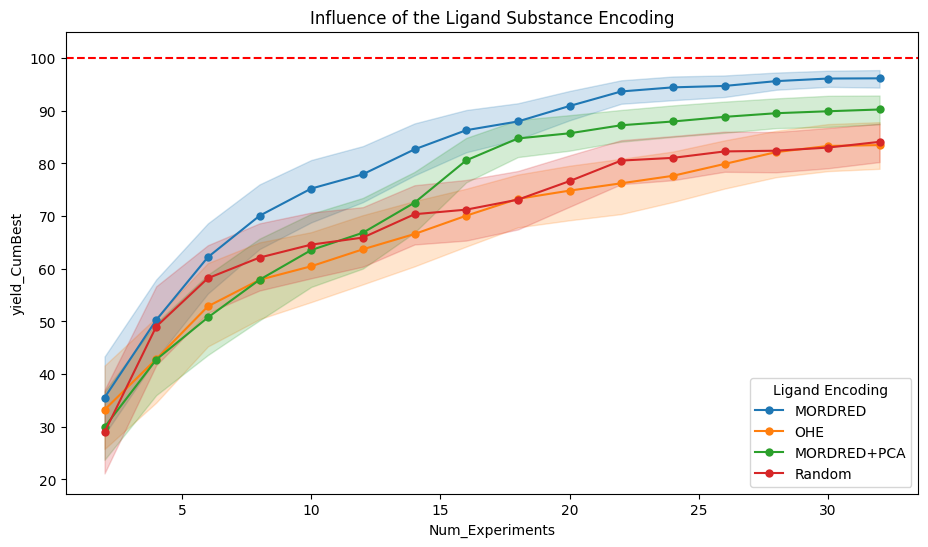

In [21]:
PLOTARGS = {
    'linestyle': 'solid',
    'marker': 'o',
    'markersize': 6, 
    'markeredgecolor': 'none'
}
FIGSIZE = (11,6)

results.rename(columns = {"Scenario": "Ligand Encoding"}, inplace = True)
sns.lineplot(data = results, 
             x = "Num_Experiments", 
             y = "yield_CumBest", 
             hue = "Ligand Encoding",
             **PLOTARGS)

plt.axhline(y = F_BEST, color = 'red', linestyle = '--', label = 'Best Possible')
plt.gcf().set_size_inches(FIGSIZE)
plt.gca().set_ylim(plt.gca().get_ylim()[0], F_BEST+5)
plt.title('Influence of the Ligand Substance Encoding');